## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import necessary libraries

In [3]:
import os
from pathlib import Path
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB5
from collections import Counter
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
import cv2
from tensorflow.keras.models import load_model

## Creating folders for learning

In [ ]:
base_path = Path('/content/drive/My Drive/final_project/Dataset/ForLearning')
fireant_path = base_path / 'FireAnt' / 'images'
native_base_path = base_path / 'Native'

# Move all Native images into one folder
native_combined_path = base_path / 'NativeCombined'
native_combined_path.mkdir(exist_ok=True)

for species_folder in native_base_path.glob('*/images'):
    for img_file in species_folder.glob('*.jp*g'):
        dest = native_combined_path / img_file.name
        count = 1
        while dest.exists():  # avoid overwriting
            dest = native_combined_path / f"{img_file.stem}_{count}{img_file.suffix}"
            count += 1
        shutil.copy(img_file, dest)

# Create labeled directories for binary classification
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'
fireant_dest.mkdir(parents=True, exist_ok=True)
native_dest.mkdir(parents=True, exist_ok=True)

# Copy fire ant images
for img_file in fireant_path.glob('*.jp*g'):
    shutil.copy(img_file, fireant_dest / img_file.name)

# Copy native ant images
for img_file in native_combined_path.glob('*.jp*g'):
    shutil.copy(img_file, native_dest / img_file.name)


## Model building: EfficientNetB0

In [ ]:
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Load datasets with 80/20 split
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Check label mapping
print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing + EfficientNetB0
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_EfficientNetB0 = tf.keras.Model(inputs, outputs)

# Compile
model_EfficientNetB0.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_EfficientNetB0 = model_EfficientNetB0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_EfficientNetB0.save('/content/drive/My Drive/final_project/fire_ant_detector_EfficientNetB0_2.keras')

Class weights: {0: np.float64(1.1568125173082249), 1: np.float64(0.8806261199536207)}
Found 16709 files belonging to 2 classes.
Using 13368 files for training.
Found 16709 files belonging to 2 classes.
Using 3341 files for validation.
Class names: ['FireAnt', 'Native']
Epoch 1/20
417/418 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6789 - loss: 0.5888
Epoch 1: val_loss improved from inf to 0.44535, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 132s 290ms/step - accuracy: 0.6790 - loss: 0.5886 - val_accuracy: 0.7932 - val_loss: 0.4454
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7581 - loss: 0.4959
Epoch 2: val_loss improved from 0.44535 to 0.41776, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.7581 - loss: 0.4959 - val_accuracy: 0.8048 - val_loss: 0.4178
Epoch 3/20
418/41

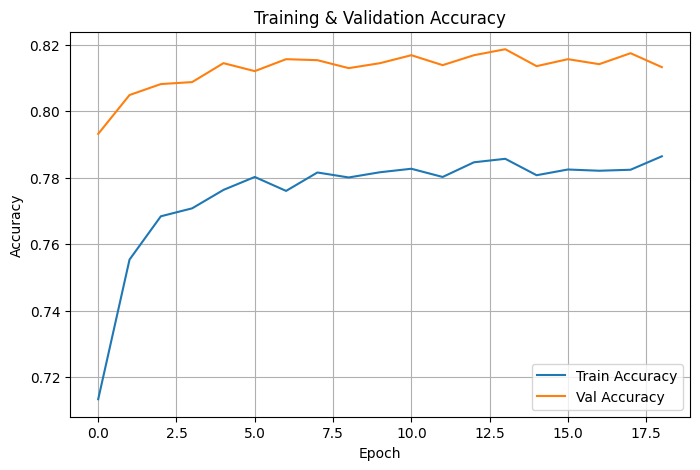

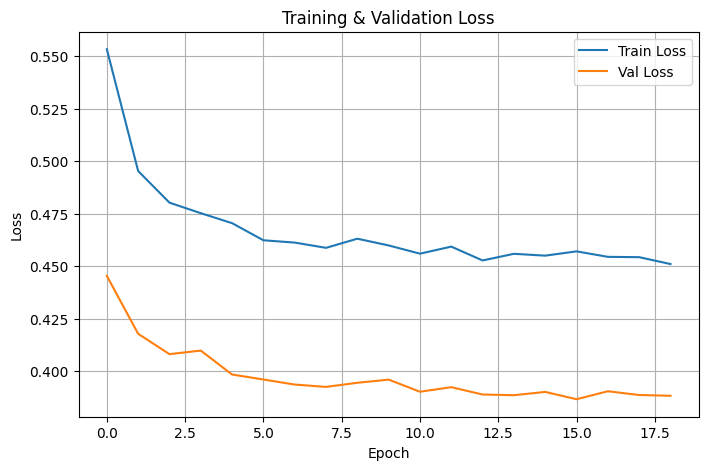

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB0.history['accuracy'], label='Train Accuracy')
plt.plot(history_EfficientNetB0.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB0.history['loss'], label='Train Loss')
plt.plot(history_EfficientNetB0.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-34-8cd54b96ef78>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step


<Figure size 600x600 with 0 Axes>

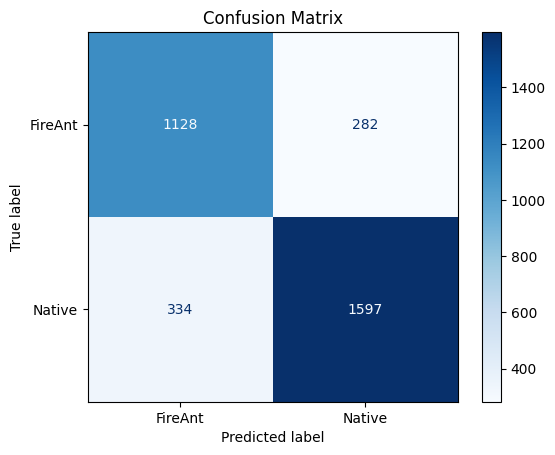

Accuracy:  0.8156
Precision: 0.8499
Recall:    0.8270
F1 Score:  0.8383


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_EfficientNetB0.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_EfficientNetB0.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Model building: EfficientNetB0 with middle quality images

In [ ]:
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForBinaryMiddleQualityImages')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Load datasets with 80/20 split
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Check label mapping
print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing + EfficientNetB0
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_EfficientNetB0_qua = tf.keras.Model(inputs, outputs)

# Compile
model_EfficientNetB0_qua.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_qua_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_EfficientNetB0_qua = model_EfficientNetB0_qua.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_EfficientNetB0_qua.save('/content/drive/My Drive/final_project/fire_ant_detector_EfficientNetB0_qua.keras')

Class weights: {0: np.float64(1.238628762541806), 1: np.float64(0.8384650215078108)}
Found 14824 files belonging to 2 classes.
Using 11860 files for training.
Found 14824 files belonging to 2 classes.
Using 2964 files for validation.
Class names: ['FireAnt', 'Native']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.6654 - loss: 0.6006
Epoch 1: val_loss improved from inf to 0.45447, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_qua_cp.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.6655 - loss: 0.6005 - val_accuracy: 0.7797 - val_loss: 0.4545
Epoch 2/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7422 - loss: 0.5142
Epoch 2: val_loss improved from 0.45447 to 0.42636, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_qua_cp.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.7423 - loss: 0.5142 - va

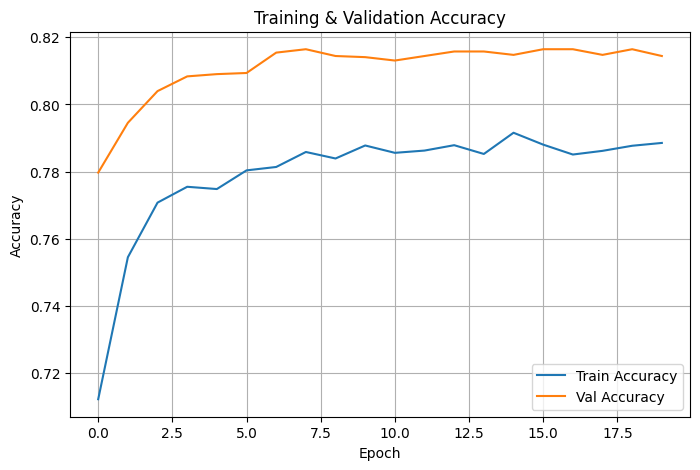

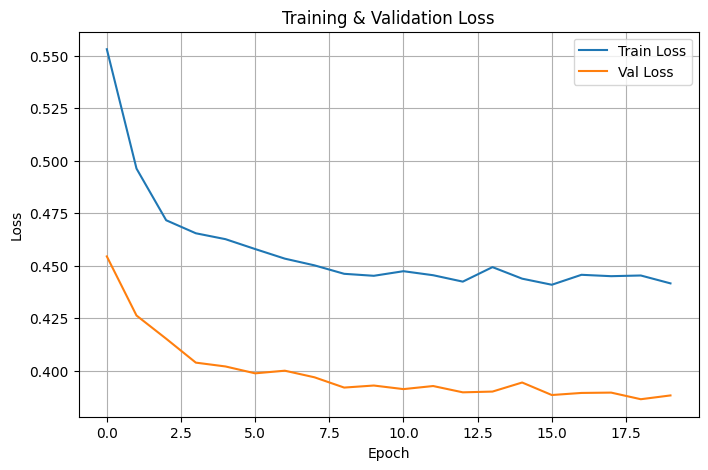

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB0_qua.history['accuracy'], label='Train Accuracy')
plt.plot(history_EfficientNetB0_qua.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB0_qua.history['loss'], label='Train Loss')
plt.plot(history_EfficientNetB0_qua.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-4-f02c48d8532b>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step


<Figure size 600x600 with 0 Axes>

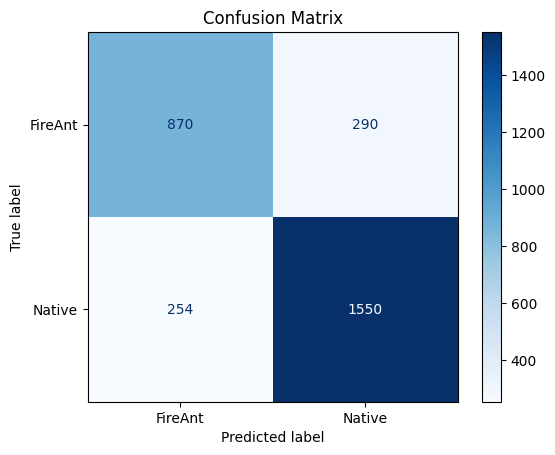

Accuracy:  0.8165
Precision: 0.8424
Recall:    0.8592
F1 Score:  0.8507


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_EfficientNetB0_qua.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_EfficientNetB0_qua.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: EfficientNetB0 with high quality images

In [ ]:
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForBinaryHighQualityImages')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Load datasets with 80/20 split
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Check label mapping
print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing + EfficientNetB0
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_EfficientNetB0_high = tf.keras.Model(inputs, outputs)

# Compile
model_EfficientNetB0_high.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_high_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_EfficientNetB0_high = model_EfficientNetB0_high.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_EfficientNetB0_high.save('/content/drive/My Drive/final_project/fire_ant_detector_EfficientNetB0_high.keras')

Class weights: {0: np.float64(1.3234403391883707), 1: np.float64(0.8036042662743655)}
Found 13118 files belonging to 2 classes.
Using 10495 files for training.
Found 13118 files belonging to 2 classes.
Using 2623 files for validation.
Class names: ['FireAnt', 'Native']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6511 - loss: 0.6093
Epoch 1: val_loss improved from inf to 0.44432, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_high_cp.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.6512 - loss: 0.6092 - val_accuracy: 0.7941 - val_loss: 0.4443
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7594 - loss: 0.4940
Epoch 2: val_loss improved from 0.44432 to 0.41426, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB0_high_cp.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.7594 - loss: 0.4939 - va

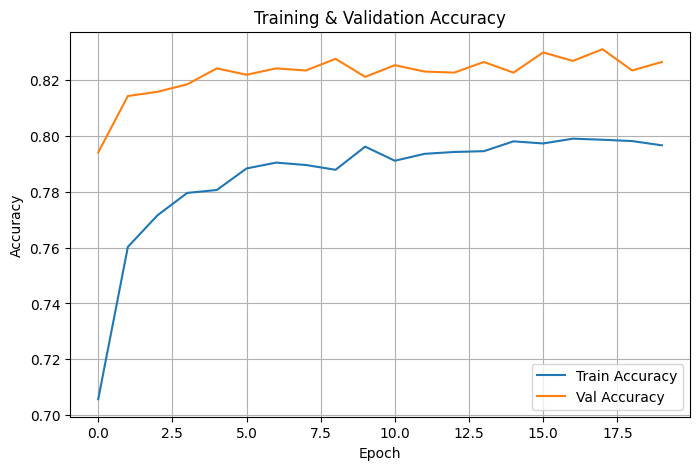

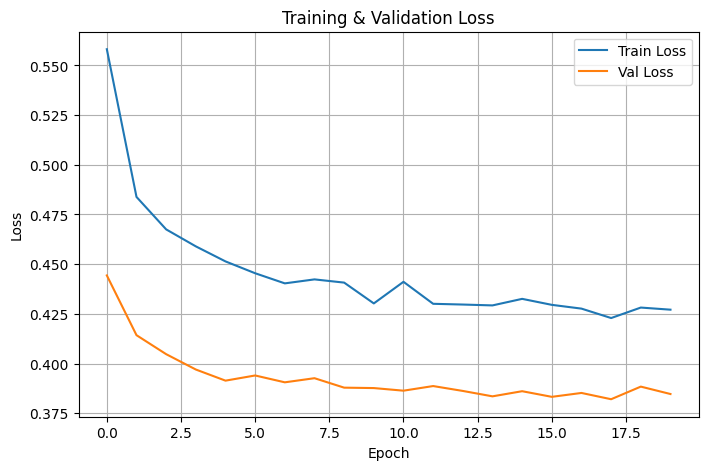

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB0_high.history['accuracy'], label='Train Accuracy')
plt.plot(history_EfficientNetB0_high.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB0_high.history['loss'], label='Train Loss')
plt.plot(history_EfficientNetB0_high.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-5-f94b8d03e964>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step


<Figure size 600x600 with 0 Axes>

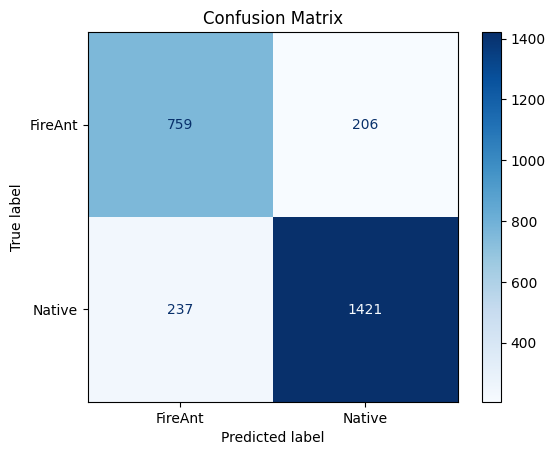

Accuracy:  0.8311
Precision: 0.8734
Recall:    0.8571
F1 Score:  0.8651


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_EfficientNetB0_high.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_EfficientNetB0_high.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: ResNet50

In [ ]:
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Load datasets with 80/20 split
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Check label mapping
print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing + ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Define a custom preprocessing layer to ensure accurate saving
class PreprocessingLayer(layers.Layer):
    def call(self, inputs):
        return preprocess_input(inputs)

# Load ResNet50 base
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base model

# Build model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = PreprocessingLayer()(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_ResNet50 = models.Model(inputs, outputs)

# Compile
model_ResNet50.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_ResNet50 = model_ResNet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_ResNet50.save('/content/drive/My Drive/final_project/fire_ant_detector_ResNet50_3.keras')

Class weights: {0: np.float64(1.1568125173082249), 1: np.float64(0.8806261199536207)}
Found 16709 files belonging to 2 classes.
Using 13368 files for training.
Found 16709 files belonging to 2 classes.
Using 3341 files for validation.
Class names: ['FireAnt', 'Native']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6715 - loss: 0.6239
Epoch 1: val_loss improved from inf to 0.44688, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 875s 2s/step - accuracy: 0.6716 - loss: 0.6238 - val_accuracy: 0.7953 - val_loss: 0.4469
Epoch 2/20
417/418 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7570 - loss: 0.5002
Epoch 2: val_loss improved from 0.44688 to 0.42575, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.7570 - loss: 0.5001 - val_accuracy: 0.8120 - v

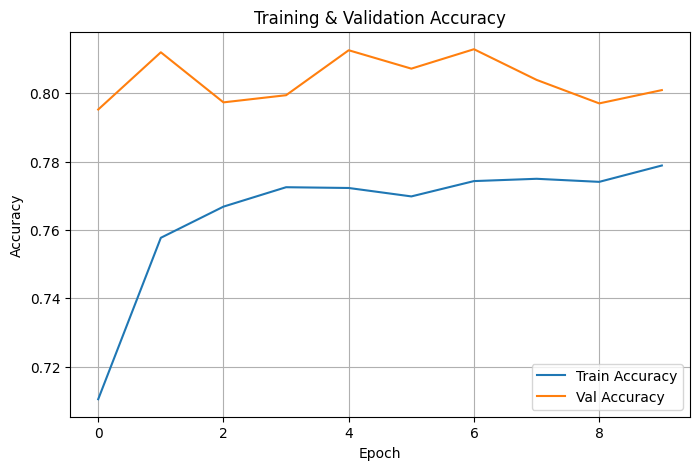

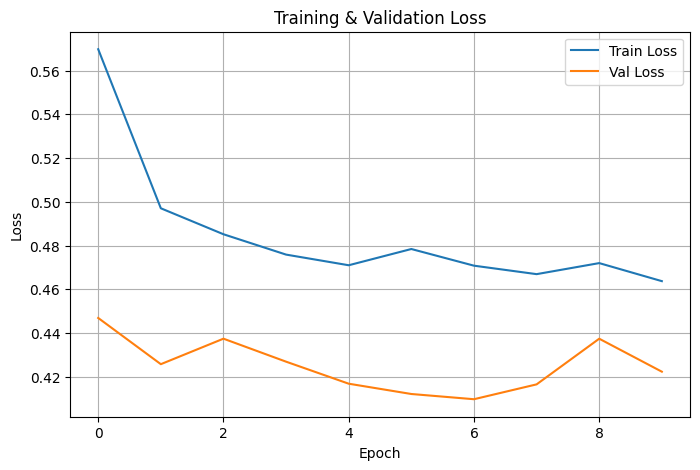

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_ResNet50.history['accuracy'], label='Train Accuracy')
plt.plot(history_ResNet50.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_ResNet50.history['loss'], label='Train Loss')
plt.plot(history_ResNet50.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-5-7b35000bd83b>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step


<Figure size 600x600 with 0 Axes>

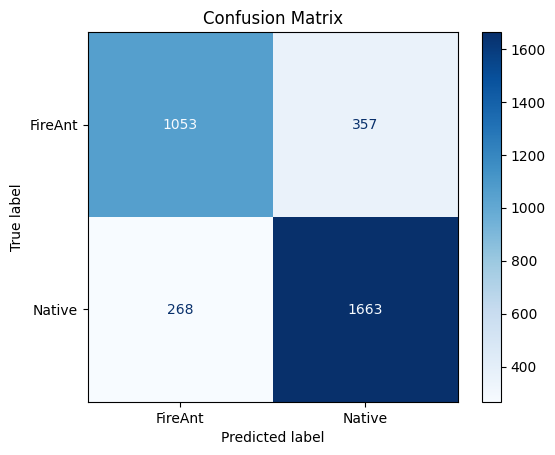

Accuracy:  0.8129
Precision: 0.8233
Recall:    0.8612
F1 Score:  0.8418


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_ResNet50.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_ResNet50.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: ResNet50 with middle quality images

In [ ]:
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForBinaryMiddleQualityImages')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Load datasets with 80/20 split
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Check label mapping
print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing + ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Define a custom preprocessing layer to ensure accurate saving
class PreprocessingLayer(layers.Layer):
    def call(self, inputs):
        return preprocess_input(inputs)

# Load ResNet50 base
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base model

# Build model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = PreprocessingLayer()(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_ResNet50_qua = models.Model(inputs, outputs)

# Compile
model_ResNet50_qua.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_mid_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_ResNet50_qua = model_ResNet50_qua.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_ResNet50_qua.save('/content/drive/My Drive/final_project/fire_ant_detector_ResNet50_mid2.keras')

Class weights: {0: np.float64(1.238628762541806), 1: np.float64(0.8384650215078108)}
Found 14824 files belonging to 2 classes.
Using 11860 files for training.
Found 14824 files belonging to 2 classes.
Using 2964 files for validation.
Class names: ['FireAnt', 'Native']
Epoch 1/20
370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6482 - loss: 0.6491
Epoch 1: val_loss improved from inf to 0.46775, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_mid_cp.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 117s 295ms/step - accuracy: 0.6485 - loss: 0.6487 - val_accuracy: 0.7740 - val_loss: 0.4677
Epoch 2/20
370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7483 - loss: 0.5147
Epoch 2: val_loss improved from 0.46775 to 0.44480, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_mid_cp.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.7483 - loss: 0.5146 - val_accuracy: 0.7928 - val_loss: 0.4448
Epoch 3/20
370/371 ━━━

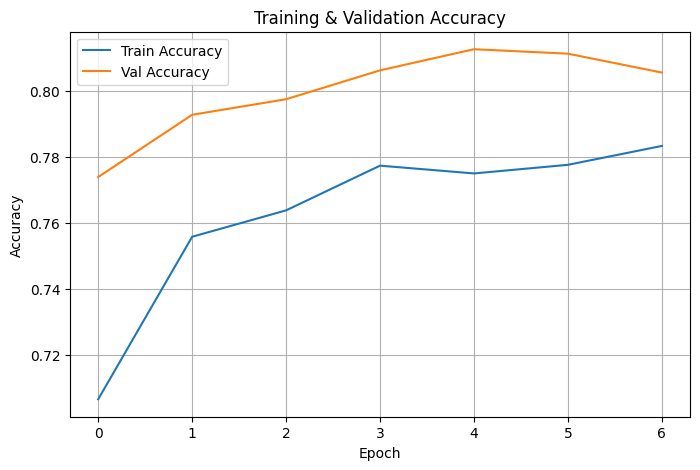

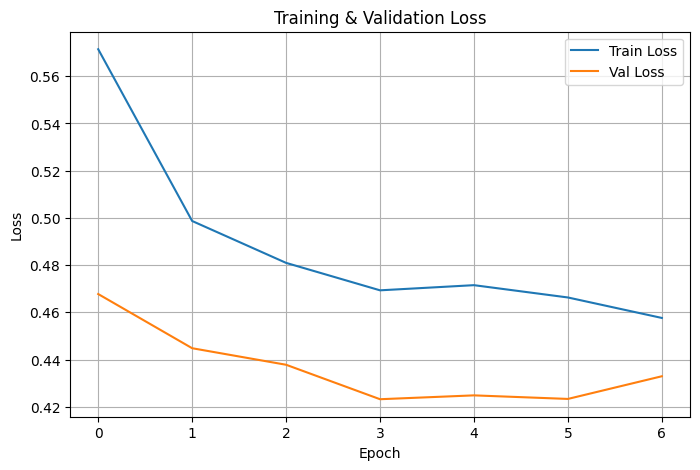

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_ResNet50_qua.history['accuracy'], label='Train Accuracy')
plt.plot(history_ResNet50_qua.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_ResNet50_qua.history['loss'], label='Train Loss')
plt.plot(history_ResNet50_qua.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-10-94af5c1b6c64>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step


<Figure size 600x600 with 0 Axes>

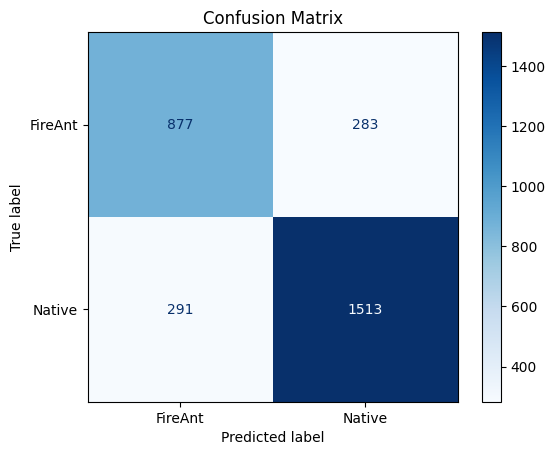

Accuracy:  0.8063
Precision: 0.8424
Recall:    0.8387
F1 Score:  0.8406


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_ResNet50_qua.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_ResNet50_qua.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: ResNet50 with high quality images

In [ ]:
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForBinaryHighQualityImages')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Load datasets with 80/20 split
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Check label mapping
print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing + ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Define a custom preprocessing layer to ensure accurate saving
class PreprocessingLayer(layers.Layer):
    def call(self, inputs):
        return preprocess_input(inputs)

# Load ResNet50 base
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base model

# Build model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = PreprocessingLayer()(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_ResNet50_high = models.Model(inputs, outputs)

# Compile
model_ResNet50_high.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_high_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_ResNet50_high = model_ResNet50_high.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_ResNet50_high.save('/content/drive/My Drive/final_project/fire_ant_detector_ResNet50_high2.keras')

Class weights: {0: np.float64(1.3234403391883707), 1: np.float64(0.8036042662743655)}
Found 13118 files belonging to 2 classes.
Using 10495 files for training.
Found 13118 files belonging to 2 classes.
Using 2623 files for validation.
Class names: ['FireAnt', 'Native']
Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6505 - loss: 0.6578
Epoch 1: val_loss improved from inf to 0.43061, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_high_cp.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.6507 - loss: 0.6576 - val_accuracy: 0.8067 - val_loss: 0.4306
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7525 - loss: 0.5023
Epoch 2: val_loss improved from 0.43061 to 0.41128, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_ResNet50_high_cp.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.7525 - loss: 0.5023 - val_accuracy: 0.8166 - val_loss: 0.4113
Epoch 3/20
328/328 ━━━━━━

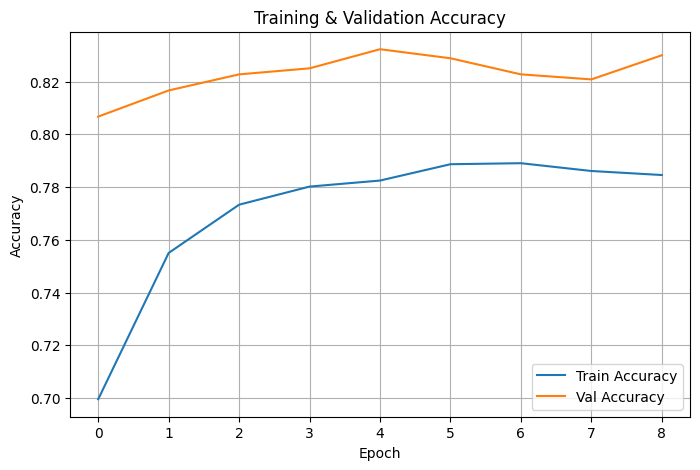

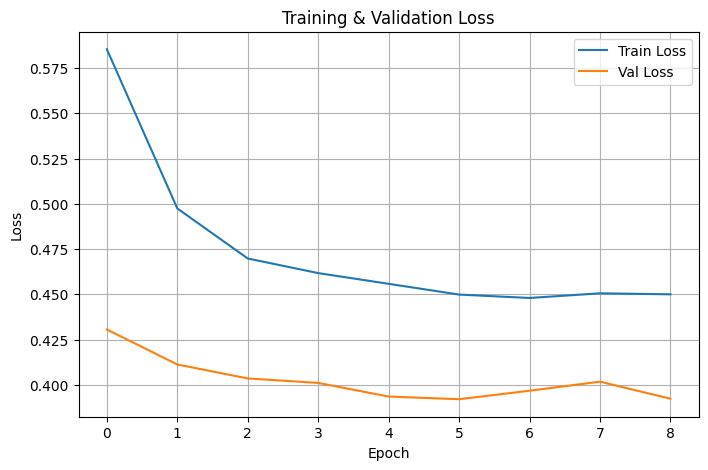

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_ResNet50_high.history['accuracy'], label='Train Accuracy')
plt.plot(history_ResNet50_high.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_ResNet50_high.history['loss'], label='Train Loss')
plt.plot(history_ResNet50_high.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-14-5c8c4cb89ee6>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step


<Figure size 600x600 with 0 Axes>

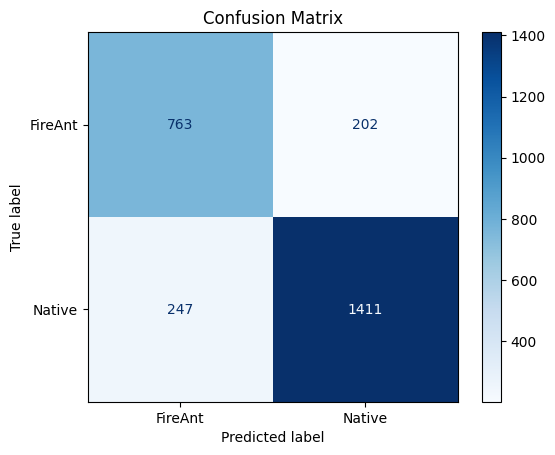

Accuracy:  0.8288
Precision: 0.8748
Recall:    0.8510
F1 Score:  0.8627


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_ResNet50_high.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_ResNet50_high.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: Xception

In [ ]:
# Dataset paths
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count samples
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))
total = fireant_count + native_count

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Load datasets
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

print("Class names:", train_ds.class_names)

# Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing + Xception
preprocess_input = tf.keras.applications.xception.preprocess_input

# Load Xception base model
base_model = Xception(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_Xception = tf.keras.Model(inputs, outputs)

# Compile
model_Xception.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set checkpoint path
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_Xception_cp.keras'

# Callbacks
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_Xception = model_Xception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save full model
model_Xception.save('/content/drive/My Drive/final_project/fire_ant_detector_Xception.keras')

Class weights: {0: np.float64(1.1568125173082249), 1: np.float64(0.8806261199536207)}
Found 16709 files belonging to 2 classes.
Using 13368 files for training.
Found 16709 files belonging to 2 classes.
Using 3341 files for validation.
Class names: ['FireAnt', 'Native']
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6533 - loss: 0.6227
Epoch 1: val_loss improved from inf to 0.50876, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_Xception_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.6533 - loss: 0.6226 - val_accuracy: 0.7579 - val_loss: 0.5088
Epoch 2/20
417/418 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7183 - loss: 0.5467
Epoch 2: val_loss improved from 0.50876 to 0.49174, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_Xception_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step - accuracy: 0.7183 - loss: 0.5467 - val_accuracy: 0.7653 - v

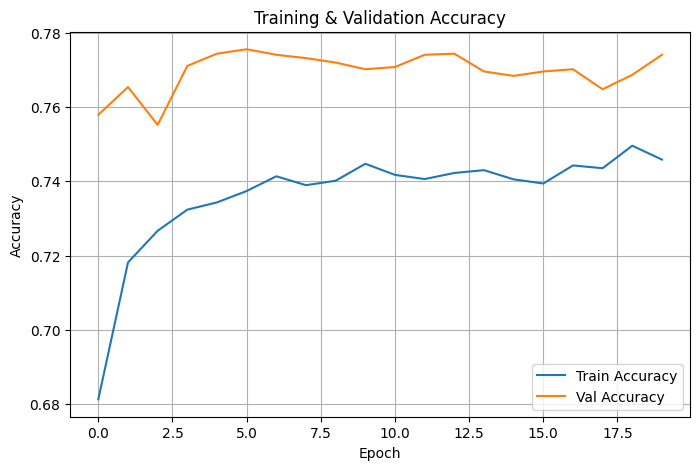

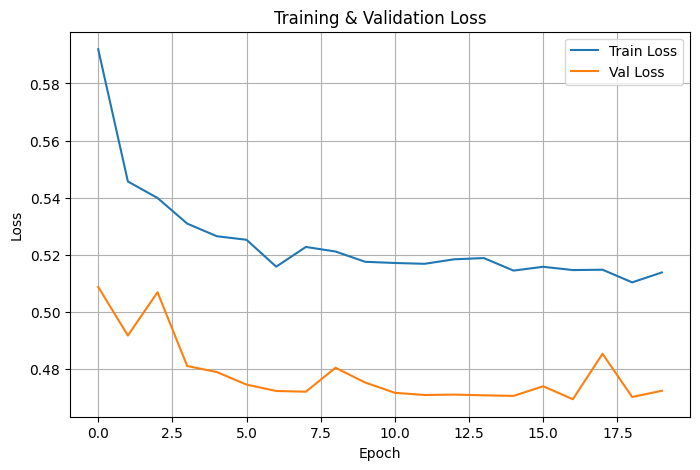

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_Xception.history['accuracy'], label='Train Accuracy')
plt.plot(history_Xception.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_Xception.history['loss'], label='Train Loss')
plt.plot(history_Xception.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-5-748e893a4691>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step


<Figure size 600x600 with 0 Axes>

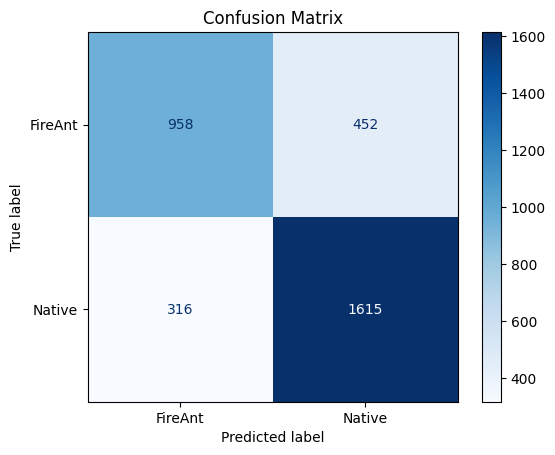

Accuracy:  0.7701
Precision: 0.7813
Recall:    0.8364
F1 Score:  0.8079


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_Xception.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_Xception.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: EfficientNetB5

In [ ]:
# Dataset path
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (456, 456)  # EfficientNetB5 requires larger input size
SEED = 42

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Load EfficientNetB5
base_model = EfficientNetB5(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_EfficientNetB5 = tf.keras.Model(inputs, outputs)

# Compile
model_EfficientNetB5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_cp.keras'
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_EfficientNetB5 = model_EfficientNetB5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_EfficientNetB5.save('/content/drive/My Drive/final_project/fire_ant_detector_EfficientNetB5.keras')

Class weights: {0: np.float64(1.1568125173082249), 1: np.float64(0.8806261199536207)}
Found 16709 files belonging to 2 classes.
Using 13368 files for training.
Found 16709 files belonging to 2 classes.
Using 3341 files for validation.
Class names: ['FireAnt', 'Native']
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7044 - loss: 0.5770
Epoch 1: val_loss improved from inf to 0.44772, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.7044 - loss: 0.5769 - val_accuracy: 0.8078 - val_loss: 0.4477
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.7781 - loss: 0.4779
Epoch 2: val_loss improved from 0.44772 to 0.41291, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 358s 858ms/step - accuracy: 0.7781 - loss: 0.4779 - val_acc

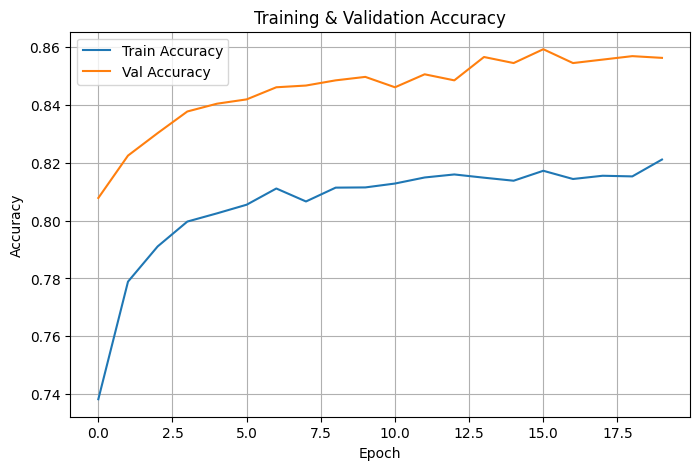

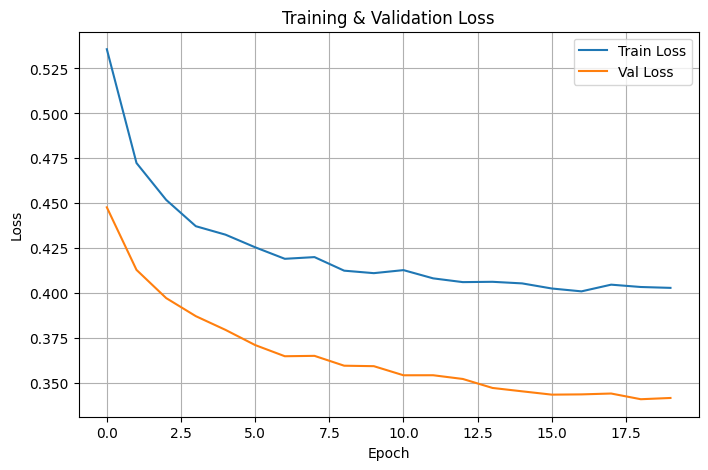

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB5.history['accuracy'], label='Train Accuracy')
plt.plot(history_EfficientNetB5.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB5.history['loss'], label='Train Loss')
plt.plot(history_EfficientNetB5.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-5-7091496ee5b0>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 726ms/step


<Figure size 600x600 with 0 Axes>

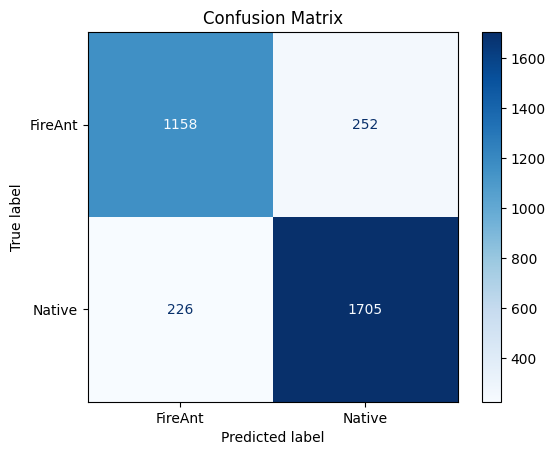

Accuracy:  0.8569
Precision: 0.8712
Recall:    0.8830
F1 Score:  0.8771


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_EfficientNetB5.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_EfficientNetB5.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: EfficientNetB5 with middle quality images

In [ ]:
# Dataset path
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForBinaryMiddleQualityImages')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (456, 456)  # EfficientNetB5 requires larger input size
SEED = 42

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Load EfficientNetB5
base_model = EfficientNetB5(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_EfficientNetB5_mid = tf.keras.Model(inputs, outputs)

# Compile
model_EfficientNetB5_mid.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_mid_cp.keras'
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_EfficientNetB5_mid = model_EfficientNetB5_mid.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_EfficientNetB5_mid.save('/content/drive/My Drive/final_project/fire_ant_detector_EfficientNetB5_mid.keras')

Class weights: {0: np.float64(1.238628762541806), 1: np.float64(0.8384650215078108)}
Found 14824 files belonging to 2 classes.
Using 11860 files for training.
Found 14824 files belonging to 2 classes.
Using 2964 files for validation.
Class names: ['FireAnt', 'Native']
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.6819 - loss: 0.5932
Epoch 1: val_loss improved from inf to 0.45531, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_mid_cp.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 359s 885ms/step - accuracy: 0.6820 - loss: 0.5930 - val_accuracy: 0.7891 - val_loss: 0.4553
Epoch 2/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7705 - loss: 0.4865
Epoch 2: val_loss improved from 0.45531 to 0.42031, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_mid_cp.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 85s 230ms/step - accuracy: 0.7705 - loss: 0.48

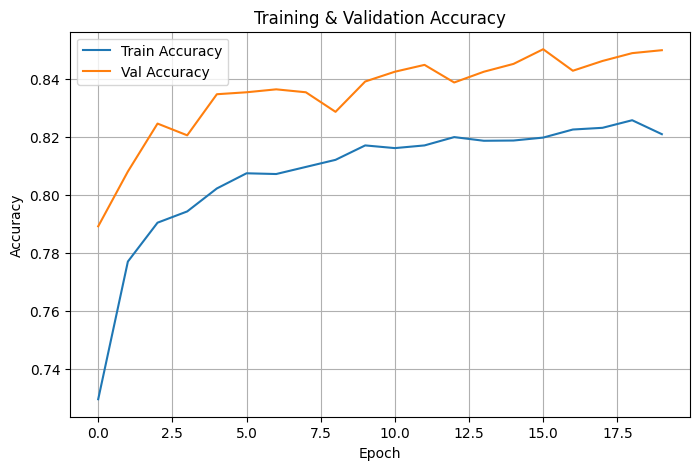

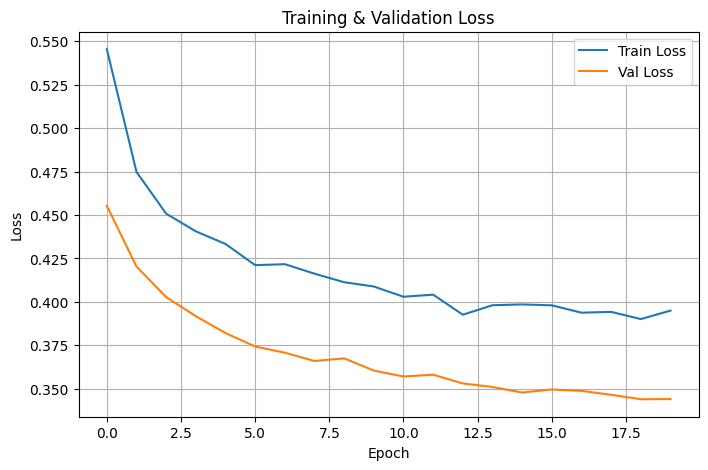

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB5_mid.history['accuracy'], label='Train Accuracy')
plt.plot(history_EfficientNetB5_mid.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB5_mid.history['loss'], label='Train Loss')
plt.plot(history_EfficientNetB5_mid.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-5-ba0c38e137c9>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step


<Figure size 600x600 with 0 Axes>

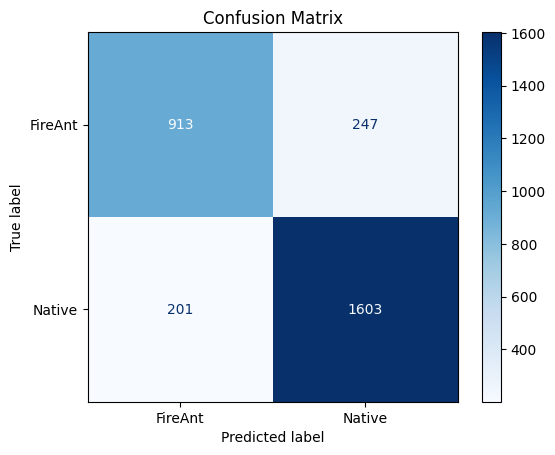

Accuracy:  0.8489
Precision: 0.8665
Recall:    0.8886
F1 Score:  0.8774


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_EfficientNetB5_mid.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_EfficientNetB5_mid.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: EfficientNetB5 with high quality images

In [3]:
# Dataset path
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForBinaryHighQualityImages')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (456, 456)  # EfficientNetB5 requires larger input size
SEED = 42

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

print("Class names:", train_ds.class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Load EfficientNetB5
base_model = EfficientNetB5(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_EfficientNetB5_high = tf.keras.Model(inputs, outputs)

# Compile
model_EfficientNetB5_high.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_high_cp.keras'
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_EfficientNetB5_high = model_EfficientNetB5_high.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# Save model
model_EfficientNetB5_high.save('/content/drive/My Drive/final_project/fire_ant_detector_EfficientNetB5_high.keras')

Class weights: {0: np.float64(1.3234403391883707), 1: np.float64(0.8036042662743655)}
Found 13118 files belonging to 2 classes.
Using 10495 files for training.
Found 13118 files belonging to 2 classes.
Using 2623 files for validation.
Class names: ['FireAnt', 'Native']
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.6814 - loss: 0.5886
Epoch 1: val_loss improved from inf to 0.46170, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_high_cp.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 304s 842ms/step - accuracy: 0.6816 - loss: 0.5885 - val_accuracy: 0.8059 - val_loss: 0.4617
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7754 - loss: 0.4739
Epoch 2: val_loss improved from 0.46170 to 0.42154, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_EfficientNetB5_high_cp.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 76s 230ms/step - accuracy: 0.7754 - loss: 0

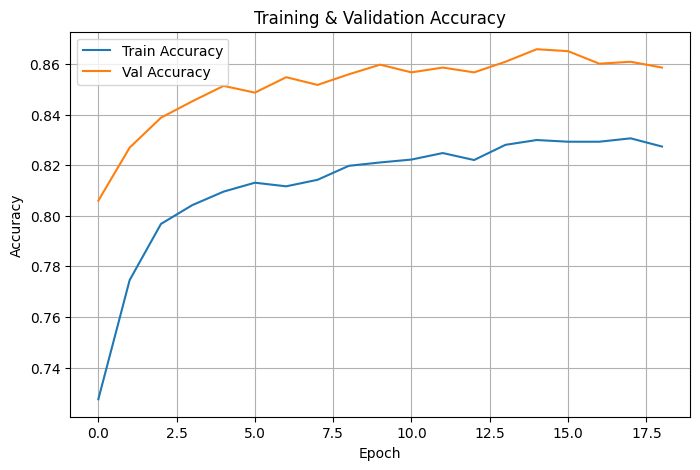

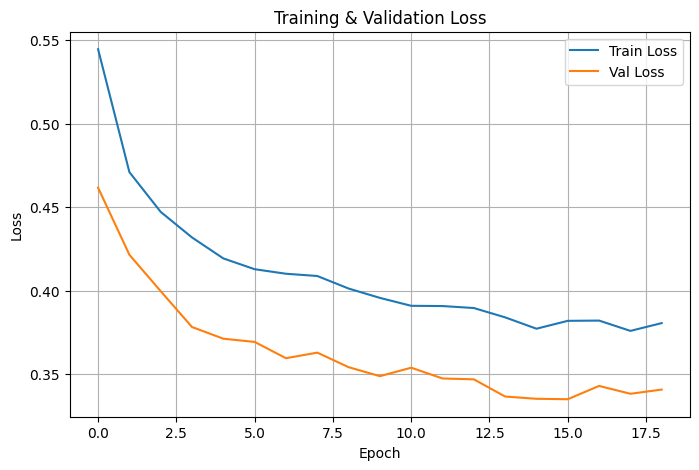

In [4]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB5_high.history['accuracy'], label='Train Accuracy')
plt.plot(history_EfficientNetB5_high.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_EfficientNetB5_high.history['loss'], label='Train Loss')
plt.plot(history_EfficientNetB5_high.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-5-e8907937e542>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step


<Figure size 600x600 with 0 Axes>

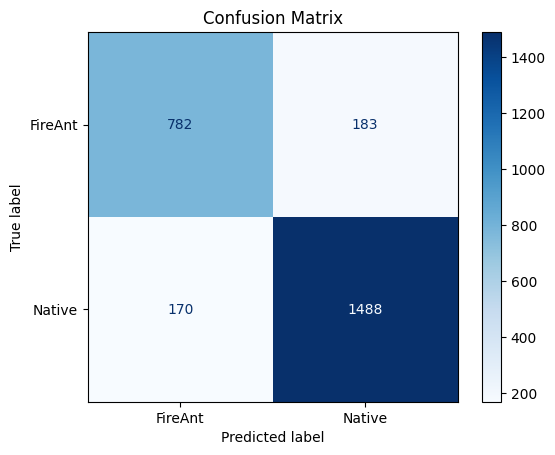

Accuracy:  0.8654
Precision: 0.8905
Recall:    0.8975
F1 Score:  0.8940


In [5]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_EfficientNetB5_high.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [6]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_EfficientNetB5_high.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Model building: Custom CNN - 3 layers

In [ ]:
base_path = Path('/content/drive/My Drive/final_project/Dataset/ForLearning')
fireant_path = base_path / 'FireAnt' / 'images'
native_base_path = base_path / 'Native'
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# === Settings ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# === Dataset Paths ===
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')

# === Load Dataset ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# === Prefetch ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# === Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# === Build Custom CNN Model ===
model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    data_augmentation,
    layers.Rescaling(1./255),  # Normalize

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# === Compile Model ===
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_customCNN_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# === Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# === Save Model ===
model.save('/content/drive/My Drive/final_project/fire_ant_detector_customCNN.keras')


Class weights: {0: np.float64(1.1568125173082249), 1: np.float64(0.8806261199536207)}
Found 16709 files belonging to 2 classes.
Using 13368 files for training.
Found 16709 files belonging to 2 classes.
Using 3341 files for validation.
Epoch 1/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5444 - loss: 0.7220
Epoch 1: val_loss improved from inf to 0.62047, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_customCNN_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 87s 200ms/step - accuracy: 0.5445 - loss: 0.7219 - val_accuracy: 0.6711 - val_loss: 0.6205
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6455 - loss: 0.6403
Epoch 2: val_loss improved from 0.62047 to 0.60466, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_customCNN_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.6455 - loss: 0.6403 - val_accuracy: 0.6848 - val_loss: 0.6047
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy

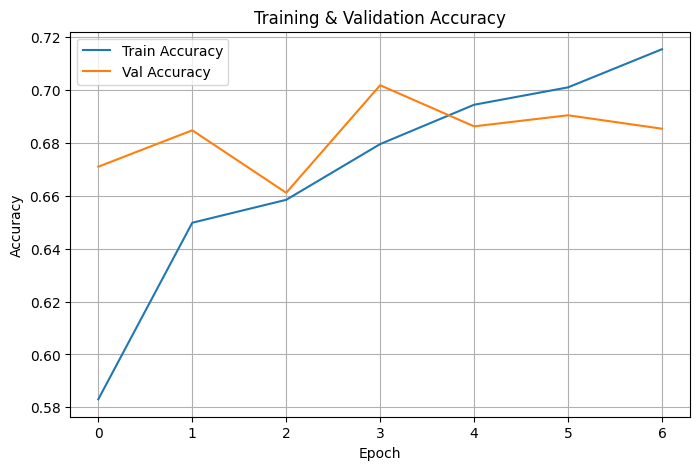

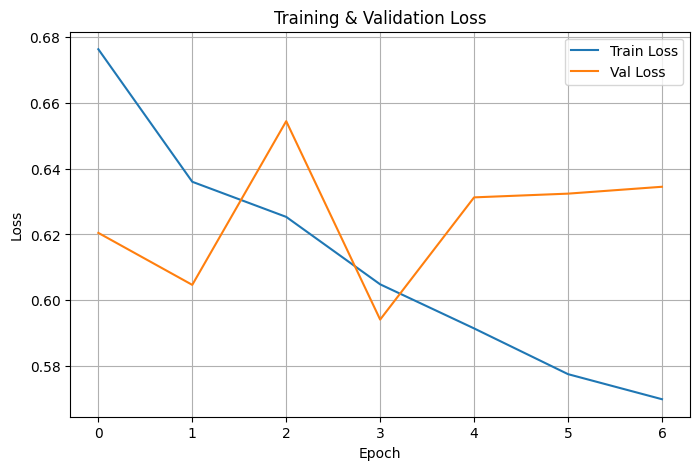

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model building: Custom CNN - 6 layers

In [ ]:
base_path = Path('/content/drive/My Drive/final_project/Dataset/ForLearning')
fireant_path = base_path / 'FireAnt' / 'images'
native_base_path = base_path / 'Native'
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# === Settings ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# === Dataset Paths ===
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')

# === Load Dataset ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# === Prefetch ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# === Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# === Build Custom CNN Model ===
model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    data_augmentation,
    layers.Rescaling(1./255),  # Normalize

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Additional layers
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Increased to combat overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# === Compile Model ===
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_customCNN6_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# === Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# === Save Model ===
model.save('/content/drive/My Drive/final_project/fire_ant_detector_customCNN6.keras')

Class weights: {0: np.float64(1.1568125173082249), 1: np.float64(0.8806261199536207)}
Found 16709 files belonging to 2 classes.
Using 13368 files for training.
Found 16709 files belonging to 2 classes.
Using 3341 files for validation.
Epoch 1/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4858 - loss: 0.6948
Epoch 1: val_loss improved from inf to 0.69393, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_customCNN6_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 110s 255ms/step - accuracy: 0.4858 - loss: 0.6948 - val_accuracy: 0.4220 - val_loss: 0.6939
Epoch 2/20
417/418 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4891 - loss: 0.6936
Epoch 2: val_loss did not improve from 0.69393
418/418 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.4890 - loss: 0.6936 - val_accuracy: 0.4220 - val_loss: 0.6944
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4715 - loss: 0.6934
Epoch 3: val_loss did not improve from 0.69393
418/418 ━━━━━━━━━━━━━━━━━━

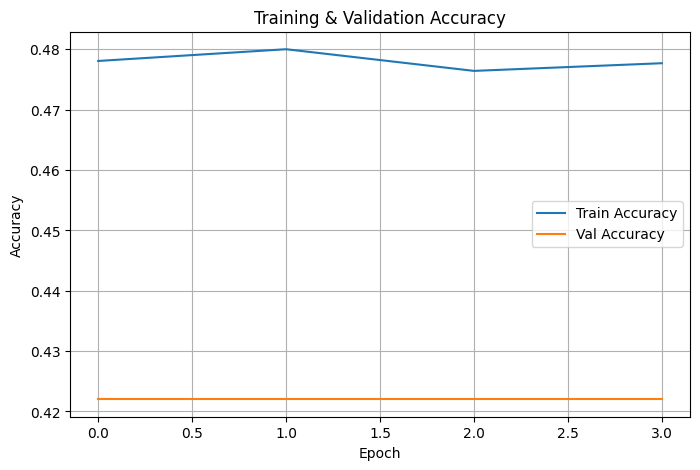

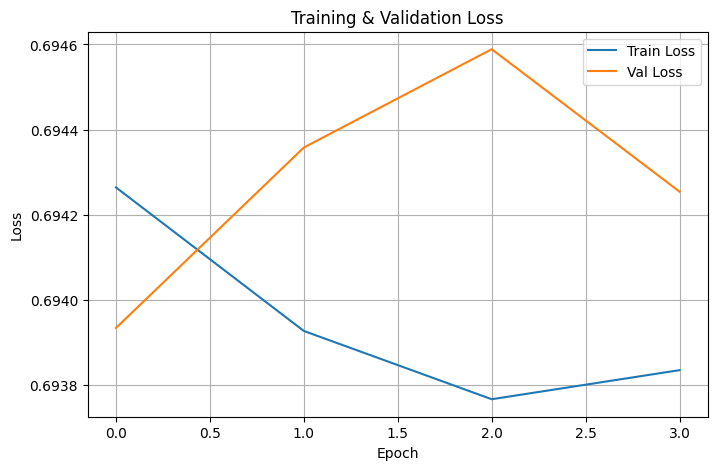

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Grid Search Loop: 3-layer Custom CNN

In [ ]:
base_path = Path('/content/drive/My Drive/final_project/Dataset/ForLearning')
fireant_path = base_path / 'FireAnt' / 'images'
native_base_path = base_path / 'Native'
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# === Settings ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 10  # keep small for faster tuning

# === Dataset Paths ===
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')

# === Load Dataset ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# === Prefetch ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# === Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# === Hyperparameter Grid ===
filters_list = [32, 64]
dense_units_list = [128, 256]
dropout_rates = [0.3, 0.5]
learning_rates = [1e-3, 1e-4]

grid = list(itertools.product(filters_list, dense_units_list, dropout_rates, learning_rates))

# === Track results ===
results = []

for filters, dense_units, dropout_rate, lr in grid:
    print(f"\nTesting: filters={filters}, dense={dense_units}, dropout={dropout_rate}, lr={lr}")

    model = models.Sequential([
        layers.Input(shape=IMG_SIZE + (3,)),
        data_augmentation,
        layers.Rescaling(1./255),

        layers.Conv2D(filters, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(filters * 2, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(filters * 4, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=0  # silent training
    )

    val_acc = history.history['val_accuracy'][-1]
    print(f"Validation Accuracy: {val_acc:.4f}")
    results.append(((filters, dense_units, dropout_rate, lr), val_acc))

# === Sort and print best ===
results.sort(key=lambda x: x[1], reverse=True)
print("\nTop 3 configurations:")
for params, acc in results[:3]:
    print(f"Params: {params}, Validation Accuracy: {acc:.4f}")

Class weights: {0: np.float64(1.1568125173082249), 1: np.float64(0.8806261199536207)}
Found 16709 files belonging to 2 classes.
Using 13368 files for training.
Found 16709 files belonging to 2 classes.
Using 3341 files for validation.

Testing: filters=32, dense=128, dropout=0.3, lr=0.001
Validation Accuracy: 0.7477

Testing: filters=32, dense=128, dropout=0.3, lr=0.0001
Validation Accuracy: 0.6582

Testing: filters=32, dense=128, dropout=0.5, lr=0.001
Validation Accuracy: 0.7160

Testing: filters=32, dense=128, dropout=0.5, lr=0.0001
Validation Accuracy: 0.6779

Testing: filters=32, dense=256, dropout=0.3, lr=0.001
Validation Accuracy: 0.7336

Testing: filters=32, dense=256, dropout=0.3, lr=0.0001
Validation Accuracy: 0.6827

Testing: filters=32, dense=256, dropout=0.5, lr=0.001
Validation Accuracy: 0.7166

Testing: filters=32, dense=256, dropout=0.5, lr=0.0001
Validation Accuracy: 0.7103

Testing: filters=64, dense=128, dropout=0.3, lr=0.001
Validation Accuracy: 0.7043

Testing: filt

## Model building: Optimized Custom CNN

In [ ]:
base_path = Path('/content/drive/My Drive/final_project/Dataset/ForLearning')
fireant_path = base_path / 'FireAnt' / 'images'
native_base_path = base_path / 'Native'
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')
fireant_dest = binary_dataset_path / 'FireAnt'
native_dest = binary_dataset_path / 'Native'

# Count number of samples per class
fireant_count = len(list(fireant_dest.glob('*.jp*g')))
native_count = len(list(native_dest.glob('*.jp*g')))

# Total
total = fireant_count + native_count

# Class weights: {class_index: weight}
# class 0: FireAnt, class 1: Native
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0] * fireant_count + [1] * native_count
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# === Settings ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# === Dataset Paths ===
binary_dataset_path = Path('/content/drive/My Drive/final_project/ForLearningBinary')

# === Load Dataset ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# === Prefetch ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# === Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# === Build Custom CNN Model ===
model_optCustom = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    data_augmentation,
    layers.Rescaling(1./255),  # Normalize

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# === Compile Model ===
model_optCustom.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set file path for saving checkpoints
checkpoint_path = '/content/drive/My Drive/final_project/checkpoints/fire_ant_optCustomCNN_cp.keras'

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # only keep the best model
    save_weights_only=False,
    verbose=1
)

# === Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# === Train ===
history_optCustom = model_optCustom.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weight_dict
)

# === Save Model ===
model_optCustom.save('/content/drive/My Drive/final_project/fire_ant_detector_OptCustomCNN.keras')

Class weights: {0: np.float64(1.1568125173082249), 1: np.float64(0.8806261199536207)}
Found 16709 files belonging to 2 classes.
Using 13368 files for training.
Found 16709 files belonging to 2 classes.
Using 3341 files for validation.
Epoch 1/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5582 - loss: 0.6950
Epoch 1: val_loss improved from inf to 0.63323, saving model to /content/drive/My Drive/final_project/checkpoints/fire_ant_optCustomCNN_cp.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 86s 201ms/step - accuracy: 0.5583 - loss: 0.6950 - val_accuracy: 0.6761 - val_loss: 0.6332
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6457 - loss: 0.6433
Epoch 2: val_loss did not improve from 0.63323
418/418 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.6457 - loss: 0.6433 - val_accuracy: 0.6432 - val_loss: 0.6336
Epoch 3/20
417/418 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6512 - loss: 0.6287
Epoch 3: val_loss improved from 0.63323 to 0.61626, saving model to /con

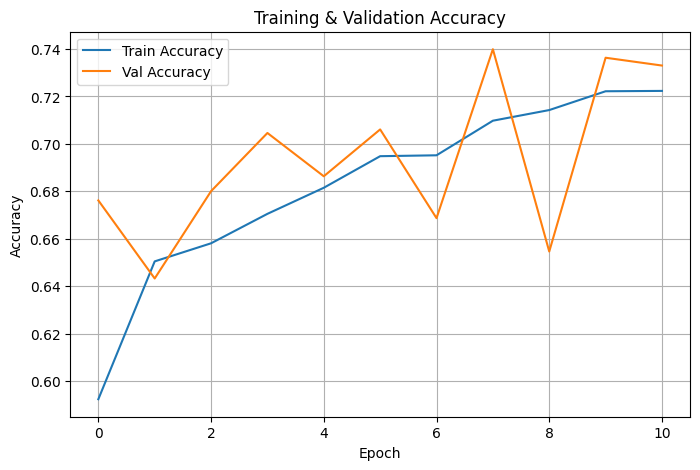

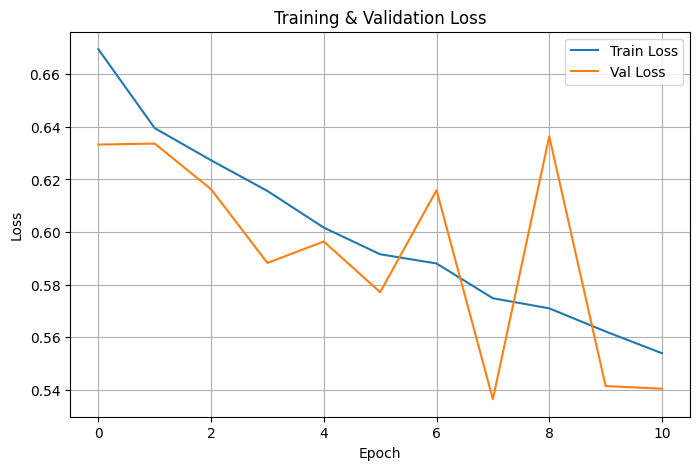

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_optCustom.history['accuracy'], label='Train Accuracy')
plt.plot(history_optCustom.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_optCustom.history['loss'], label='Train Loss')
plt.plot(history_optCustom.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-24-32c42a44a994>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_labels.append(int(labels.numpy()))


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


<Figure size 600x600 with 0 Axes>

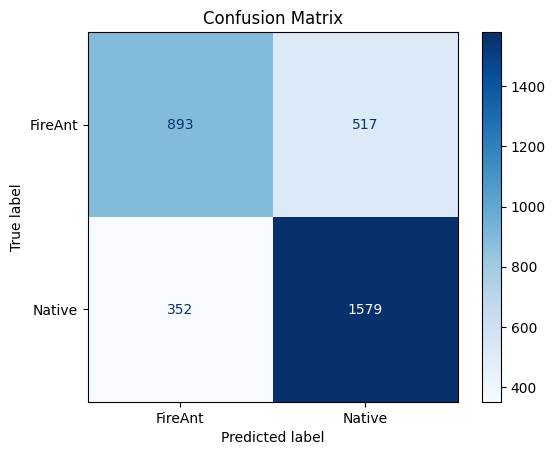

Accuracy:  0.7399
Precision: 0.7533
Recall:    0.8177
F1 Score:  0.7842


In [ ]:
# Ensure validation data is fully unbatched and in array form
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict probabilities and convert to binary class labels
pred_probs = model_optCustom.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FireAnt', 'Native'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels)
recall = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


In [ ]:
# Class names: ensure they match the order used in training
class_names = ['FireAnt', 'Native']

# Unbatch and collect all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(int(labels.numpy()))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get prediction probabilities
pred_probs = model_optCustom.predict(val_images, batch_size=32, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Identify misclassified indices
misclassified_indices = np.where(pred_labels != val_labels)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Show 10 misclassified images
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(20, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[idx].astype("uint8"))

    true_label = int(val_labels[idx])
    pred_label = int(pred_labels[idx])
    confidence = pred_probs[idx][0]

    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Class Activation Map (Grad-CAM) Visualization

In [7]:
# Load the saved model
model = load_model('/content/drive/My Drive/final_project/fire_ant_detector_EfficientNetB5_high.keras')
#model.summary()

# Set constants
BATCH_SIZE = 32
#IMG_SIZE = (224, 224)
IMG_SIZE = (456, 456)  # EfficientNetB5 requires larger input size
SEED = 42

# Load the validation dataset (again to get the file paths and labels)
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/My Drive/final_project/ForBinaryHighQualityImages',
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=1,  # important for tracking individual images
    label_mode='binary'
)

# Get image-label pairs
images = []
labels = []

for image, label in val_ds:
    images.append(image.numpy()[0])  # Since batch_size=1
    labels.append(label.numpy()[0])

images = np.array(images)
labels = np.array(labels).flatten()
print(f"Total images: {len(images)}, Total labels: {len(labels)}")

# Predict
preds = model.predict(images, batch_size=1).flatten()
print(f"Shape of predictions: {preds.shape}")
print(f"Shape of labels: {labels.shape}")
pred_classes = (preds > 0.5).astype("int")

# Identify misclassified and correctly classified indices
misclassified_indices = np.where(pred_classes != labels)[0]
correct_indices = np.where(pred_classes == labels)[0]
print(f"Total misclassified images: {len(misclassified_indices)}")
print(f"Total correctly classified images: {len(correct_indices)}")

# Get base EfficientNetB0 inside the model
base_model = model.get_layer('efficientnetb5')
last_conv_layer = model.get_layer('efficientnetb5').get_layer('top_conv')

base_input = base_model.input
last_conv_output = last_conv_layer.output
base_output = base_model.output

base_index = model.layers.index(base_model)

x = base_output
for layer in model.layers[base_index + 1:]:
    x = layer(x)

# Define Grad-CAM model: from EfficientNet input to last conv layer + final output
grad_model = tf.keras.models.Model(
    inputs=base_input,
    outputs=[last_conv_output, x]
)

# Preprocessing + EfficientNetB0
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

for layer in model.get_layer('efficientnetb5').layers[::-1]:
    if 'conv' in layer.name.lower():
        print(layer.name, layer.output.shape)
        break

def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = 0  # For binary classification, there's only one output
        class_channel = predictions[:, 0]  # Always index 0 in binary classification

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualization helper
def visualize_gradcam(indices, title_prefix):
    for i, idx in enumerate(indices[:10]):
        img = images[idx]
        true_label = int(labels[idx])
        pred_label = int(pred_classes[idx])
        confidence = preds[idx]  # Confidence score (probability)

        img_tensor = preprocess_input(tf.expand_dims(tf.cast(img, tf.float32), axis=0))

        # Heatmap for predicted class (only one available in binary)
        heatmap = make_gradcam_heatmap(img_tensor, grad_model)
        heatmap = cv2.resize(heatmap, IMG_SIZE)
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(img.astype("uint8"), 0.6, heatmap_color, 0.4, 0)

        # Display
        plt.figure(figsize=(5, 5))
        plt.title(
            f"{title_prefix} [{i+1}] - True: {true_label}, Pred: {pred_label} (Conf: {confidence:.2%})",
            fontsize=12
        )
        plt.imshow(overlay)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

# Visualize misclassified and correctly classified images
print("\nMisclassified Images:")
visualize_gradcam(misclassified_indices, "Misclassified")

print("\nCorrectly Classified Images:")
visualize_gradcam(correct_indices, "Correct")


Output hidden; open in https://colab.research.google.com to view.

## Display custom CNN summaries

In [5]:
model_3l = keras.models.load_model("Models/fire_ant_detector_OptCustomCNN.keras")
model_6l = keras.models.load_model("Models/fire_ant_detector_customCNN6.keras")

# Display the model architecture
model_3l.summary()
model_6l.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_22 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_20 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,269 (127.82 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,180 (85.21 MB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,674,693 (14.02 MB)

 Trainable params: 1,224,897 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,449,796 (9.35 MB)